# **Tesztelés címkézetlen adatokon**

Tesztelés céljából létrehozott notebook a belvíz-detektálásra.

Forrás: fastai implementáció: https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb

Készítette: Taró Bence, SZTE-TTIK Geográfus (MSc), 2020.05.08.

# **Adatok előkészítése**

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.basics import *
from fastai import *
import torch
from pathlib import Path
from zipfile import ZipFile
import cv2, imutils, json, os, sys

In [ ]:
#feltöltés
from google.colab import files

uploaded = files.upload()

In [ ]:
#kicsomagolás
filename = "data_test.zip"
#filename = "tesztelesre.zip"

with ZipFile(filename, 'r') as zippp:
  zippp.extractall()
  print('Done')

Done


In [ ]:
import sys
setpa = '/content/data_test'
path = Path(setpa)

In [ ]:
#cwd megadása
%cd /content

/content


In [ ]:
#json annotációk betöltése
annots = json.load(open(path/'output_alloviz.json'))

In [ ]:
#képek és labelek importja listába
images, lbl_bbox = get_annotations(path/'output_alloviz.json')

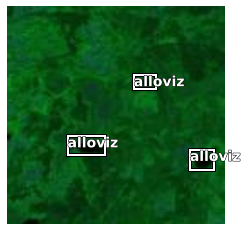

In [ ]:
#82. minta megjelenítése az annotációkkal
img = open_image(path/'JPEGImages'/images[82])
bbox = ImageBBox.create(*img.size, lbl_bbox[82][0], [0,0,0], classes=['alloviz','alloviz','alloviz'])
img.show(figsize=(6,4), y=bbox)

In [ ]:
#dictionary készítése a képekből és a hozzátartozó annotációkból
img2bbox = dict(zip(images, lbl_bbox))
#képek nevének társítása a dictionary objektumához
get_y_func = lambda o:img2bbox[os.path.basename(o)]

In [ ]:
#databunch definiálása
#bs=batch size, size=képméret
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'JPEGImages')
    src = src.split_by_rand_pct(0.2) 
    src = src.label_from_func(get_y_func)
    src = src.add_test_folder(path/'test') # teszt könyvtár hozzáadása
    src = src.transform(tfms=None, tfm_y=False) # transzformáció nem használható!
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)


In [ ]:
data = get_data(16,128)

In [ ]:
data

ImageDataBunch;

Train: LabelList (120 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /content/data_test/JPEGImages;

Valid: LabelList (29 items)
x: ObjectItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ObjectCategoryList
ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128),ImageBBox (128, 128)
Path: /content/data_test/JPEGImages;

Test: LabelList (7 items)
x: ObjectItemList
Image (3, 1000, 1000),Image (3, 128, 128),Image (3, 679, 1024),Image (3, 361, 369),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /content/data_test/JPEGImages

# **RetinaNet model definiálása**

In [ ]:
#Segédfüggvények importja az U-alakú modell felépítéséhez
#Grab the convenience functions that helps us build the Unet
from fastai.vision.models.unet import _get_sfs_idxs, model_sizes, hook_outputs

In [ ]:
class LateralUpsampleMerge(nn.Module):
    "Merge the features coming from the downsample path (in `hook`) with the upsample path."
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        self.hook = hook
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        return self.conv_lat(self.hook.stored) + F.interpolate(x, self.hook.stored.shape[-2:], mode='nearest')

In [ ]:
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize) #sfs:save features, egy 256x256 képet helyez el a ResNet modellben, hogy kinyerje a különböző méretű aktivációkat
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs))) #_get_sfs_idxs: a rétegek fordított sorrendű indexét adja vissza ahol az aktiváció mérete megváltozik a tanulás során
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs]) #hook_o: visszaadja azokat a 'hook'-okat amelyek tárolják az aktivációkat a self.stored-ban
        self.encoder = encoder #encoder=ResNet, alább: a resnet utolsó réteg-eredménye (a fpn-ben c5)
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)#conv2d: Create and initialize `nn.Conv2d` layer. `padding` defaults to `ks//2`.
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)  
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, sfs_szs[idx][1], hook) 
                                     for idx,hook in zip(sfs_idxs[-2:-4:-1], self.sfs[-2:-4:-1])])
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs) #osztályozó alkalmazása a helper függvény beállításai alapján
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs) #keretek meghatározása a helper függvény beállításai alapján
    
    # ("Each P-something feature map then goes through two subnet of four convolutional layers (with the same weights for all the feature maps)")
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "Helper function to create one of the subnet for regression/classification."
        layers = [conv_layer(chs, chs, bias=True, norm_type=None) for _ in range(n_conv)] #conv_layer: (4x) Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and batchnorm (if `bn`) layers.
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        layers[-1].bias.data.zero_().add_(final_bias) #bias alkalmazása a rétegekhez
        layers[-1].weight.data.fill_(0) #súly módsoítás
        return nn.Sequential(*layers)

    #flattens the output of our final convolutional layers that predict boxes/classes:
    def _apply_transpose(self, func, p_states, n_classes):
        #Final result of the classifier/regressor is bs * (k * n_anchors) * h * w  (k itt osztályok száma)
        #We make it bs * h * w * n_anchors * k then flatten in bs * -1 * k so we can contenate
        #all the results in bs * anchors * k (the non flatten version is there for debugging only)
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        p_states.append(self.p6top7(p_states[-1]))
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

# **Segédfüggvények**

In [ ]:
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size) #grid méret beállítása
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])# létrehoz egyforma távolságban lévő pontokat
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

#függvény a horgonyok kirajzolására
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5)) #ábrakészítés a horgonyok ábrázolásra
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    #In practice, we use different ratios and scales of that basic grid to build our anchors, 
    #because bounding boxes aren't always a perfect square inside a grid.
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0) #új tensort ad vissza a megadott érték dimenziójában
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2) #cat: összefűzi a megadott tensorokat
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [ ]:
#Keretek kirajzolási beállításai
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    #colormap megjelenítése a kerethez
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

#Modell aktivációk átvétele
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    #vagyis: átkonvertálja az anchors-ban határolt aktivációkat a modellből
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2] #Itt minden box a megadott értékek szerint tolható el valamelyik irányban
        sizes = anchors[...,2:] * torch.exp(acts[...,:2]) #Itt pedig méretében növelhető, csökkenthető a megadottak alapján
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    #compute the intersection over unions ratios between all the anchors and all the targets, 
    #then we will keep the ones that have an overlap greater than a given threshold (0.5).
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) #összefogja az anchor/target különbségeket és a részarányos értékeket adja vissza
    return sizes[...,0] * sizes[...,1]

def IoU_values(anchors, targets):
    "Compute the IoU VALUES! of `anchors` by `targets`."
    #The Intersection over Union (IoU) is a method to quantify the percent overlap between the target mask and our prediction output.
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

#A legpontosabb keretek megtartása az IoU eredményekből (kommentelt)
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    if targets.numel() == 0: return matches
    ious = IoU_values(anchors, targets)
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches


#Does the opposite of cthw2tbr.
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

#Does the opposite of activ_to_bbox.
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

def encode_class(idxs, n_classes):
    #A targetet one-hot encoded formába alakítja át
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target



In [ ]:
#RetinaNet Focal Loss felépítése
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred.detach())
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

In [ ]:
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

# **Modell paramétereinek megadása**

In [ ]:
#Itt esetleg nagyobb képek esetén érdemes a kommentelt beállítást használni!

ratios = [1/2,1,2] # oldalarány
#scales = [1,2**(-1/3), 2**(-2/3)] # oldalméret
scales = [1,2**(1/3), 2**(2/3)] #for bigger size

In [ ]:
encoder = create_body(models.resnet50, cut=-2)
model = RetinaNet(encoder, data.c, final_bias=-4)
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


# **Tanított modell betöltése driveról**

In [ ]:
#Mount drivera
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Model tárolása változóban
model_save_name = 'allapot5_3_sved_szukitett_alloviz_77p.pt'
drive_path = F"/content/gdrive/My Drive/Diplomamunka/{model_save_name}"

#Visszatöltés driveról
model = model.load_state_dict(torch.load(drive_path))

#Mentés tmp fájlba a használatra
learn.save('model_from_drive_1')

# **Eredmények vizsgálata**

In [ ]:
#learn = learn.load('allapotXXX')
learn = learn.load(path/'models/model_from_drive_1')

In [ ]:
#model export pkl-be inferenciához
learn.export()

In [ ]:
#export.pkl betöltés
learn = load_learner(path)

In [ ]:
# model->inference,gpu
learn.model.eval().cuda()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [ ]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    #to remove padding that was added to collate our targets together
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [ ]:
#Helper functions to plot the results
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

#még nem müködik:
COLORS = np.random.uniform(0, 255, size=(21, 3))
def draw_rect_image(kepfajl, b:Collection[int], text=None, col=0):
    "Draw bounding box on image."
    cv2.rectangle(kepfajl, (b[0],b[1]), (b[2],b[3]), COLORS[col], 2)

In [ ]:
def nms(boxes, scores, thresh=0.3):
    #függvény a predikciók számának csökkentésére
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None, fig=(14,14)):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz/2
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1, figsize=fig)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
# databunch test adatok
data.test_ds

LabelList (7 items)
x: ObjectItemList
Image (3, 1000, 1000),Image (3, 128, 128),Image (3, 679, 1024),Image (3, 361, 369),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /content/data_test/JPEGImages

In [ ]:
img0 = '/content/data_test/test/0012.jpg'
img1 = '/content/data_test/test/0029.jpg'
img2 = '/content/data_test/test/0035.jpg'
img3 = '/content/data_test/test/Lake_Valencia.jpg'
img4 = '/content/data_test/test/t_darab_0.jpg'
img5 = '/content/data_test/test/t_darab_0_mod.jpg'
img6 = '/content/data_test/test/t_darab_1.jpg'

In [ ]:
i2 = '/content/data_test/test/Venezuela_vagott1.jpg'
i3 = '/content/data_test/test/Venezuela_vagott2.jpg'
i4 = '/content/data_test/test/Venezuela_vagott3.jpg'

In [ ]:
# Kép konvertálása és importja a modellbe // forrás: Mohamed
ratios = [1/2,1,2] # oldalarány
#scales = [1,2**(-1/3), 2**(-2/3)] # oldalméret
scales = [1,2**(1/3), 2**(2/3)] # nagyobb képméretnél érdemes

photo = cv2.imread(img3) #tesztkep input img->np array
#kep = imutils.resize(photo,width=128,height=128) #resize, ez feltétlen szükséges
#kep = cv2.cvtColor(kep, cv2.COLOR_BGR2RGB) # színkódolást módosít
kep = pil2tensor(photo, dtype=np.float32).div_(255) # ez kerül be a modellbe (tensor)

with torch.no_grad():
    output = learn.model(kep.unsqueeze_(0).cuda())

In [ ]:
#ellenőrízni melyik idx a kép
imi = data.test_ds[2][0]
imi.shape

torch.Size([3, 679, 1024])

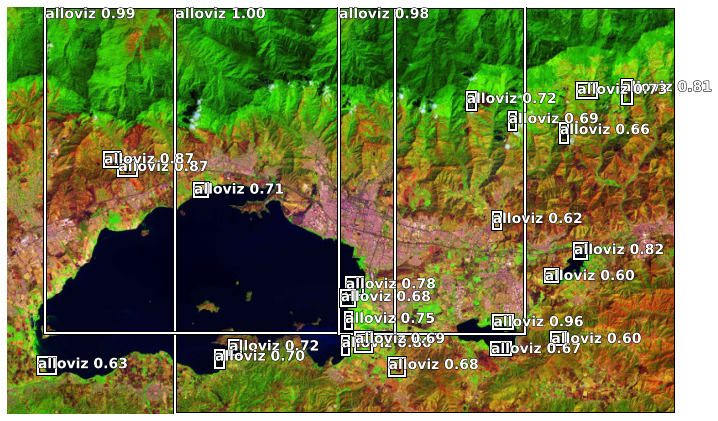

In [ ]:
imi = data.test_ds[3][0]
mutat = show_preds(imi, output, 0, detect_thresh=0.6, classes=data.classes, fig=(12,12))

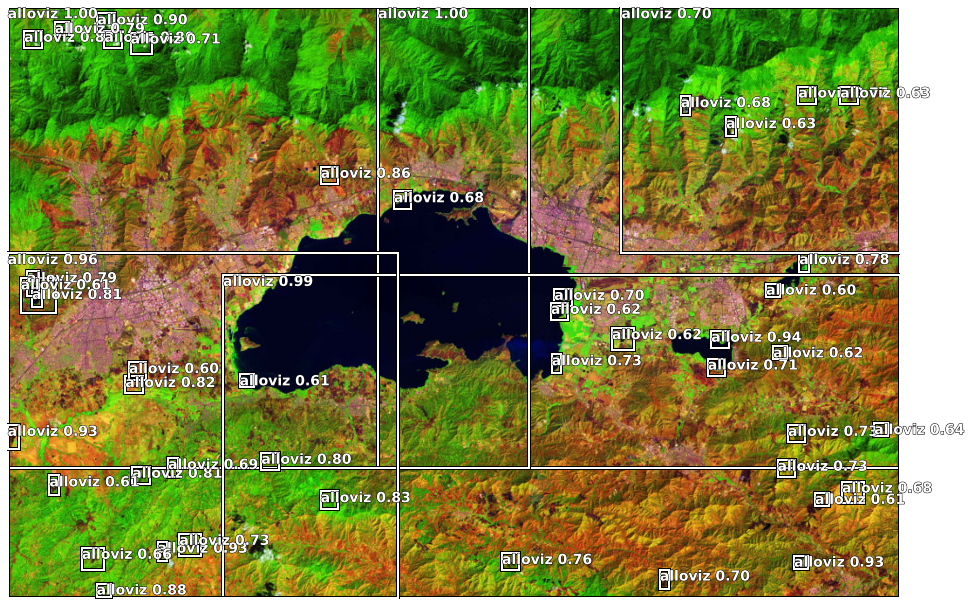

In [ ]:
imi = data.test_ds[0][0]
mutat = show_preds(imi, output, 0, detect_thresh=0.6, classes=data.classes, fig=(16,16))

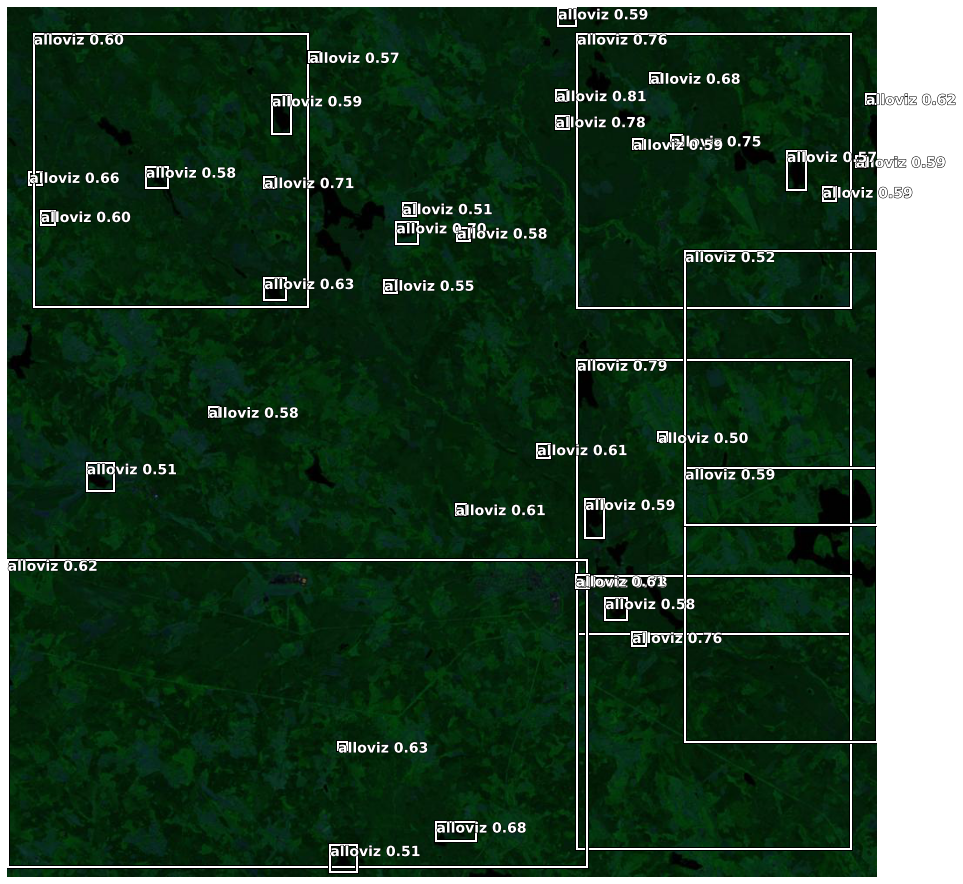

In [ ]:
imi = data.test_ds[3][0]
mutat = show_preds(imi, output, 0, detect_thresh=0.5, classes=data.classes)

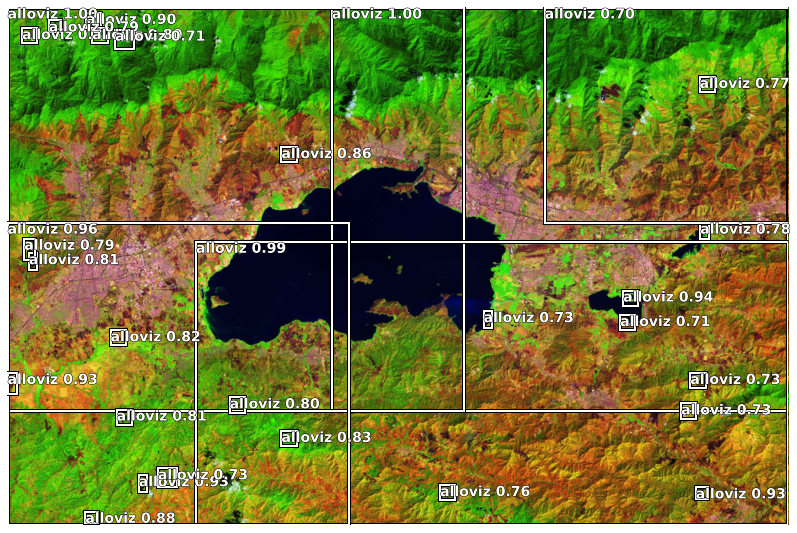

In [ ]:
# teszt méret változtatható a show_preds függvényben
imi = data.test_ds[3][0]
mutat = show_preds(imi, output, 0, detect_thresh=0.7, classes=data.classes)

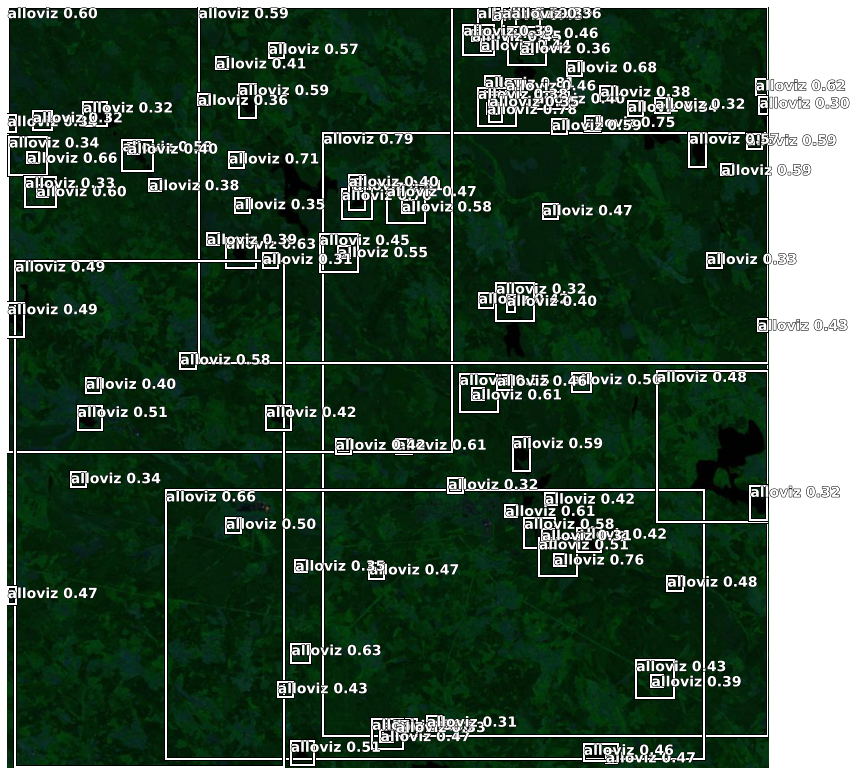

In [ ]:
# teszt_01
imi = data.test_ds[2][0]
mutat = show_preds(imi, output, 0, detect_thresh=0.3, classes=data.classes)

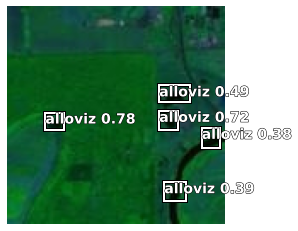

In [ ]:
# 0.kep
imi = data.test_ds[0][0]
show_preds(imi, output, 0, detect_thresh=0.3, classes=data.classes)

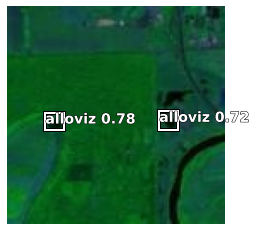

In [ ]:
# 0.kep
imi = data.test_ds[0][0]
show_preds(imi, output, 0, detect_thresh=0.6, classes=data.classes)

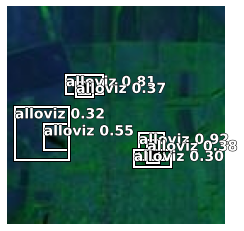

In [ ]:
# 1.kep, 6. idx
imi = data.test_ds[6][0]
show_preds(imi, output, 0, detect_thresh=0.3, classes=data.classes)

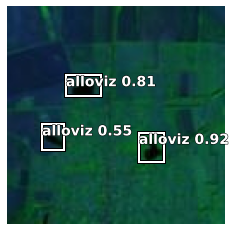

In [ ]:
# 1.kep, 6. idx, 0.5 trsh
imi = data.test_ds[6][0]
show_preds(imi, output, 0, detect_thresh=0.5, classes=data.classes)

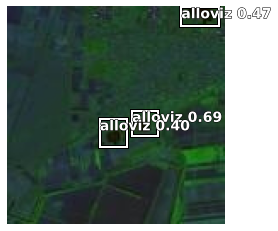

In [ ]:
# 2.kep, 4.idx
imi = data.test_ds[4][0]
show_preds(imi, output, 0, detect_thresh=0.3, classes=data.classes)

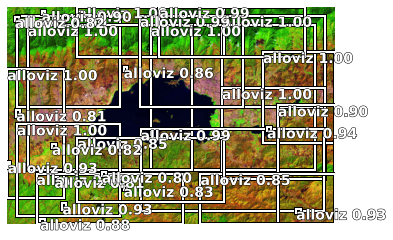

In [ ]:
#3. kep, 1.idx
imi = data.test_ds[1][0]
show_preds(imi, output, 0, detect_thresh=0.8, classes=data.classes)

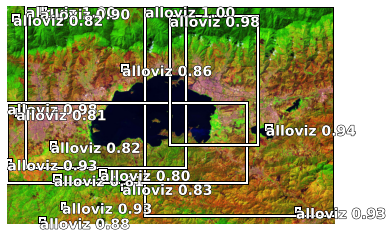

In [ ]:
#3. kep, 1.idx, nagyobb anchor size
imi = data.test_ds[1][0]
show_preds(imi, output, 0, detect_thresh=0.8, classes=data.classes)

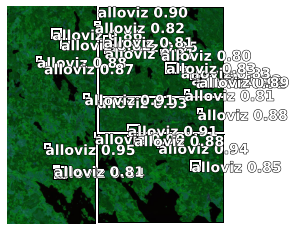

In [ ]:
# 4. kep, 2.idx
imi = data.test_ds[5][0]
show_preds(imi, output, 0, detect_thresh=0.8, classes=data.classes)

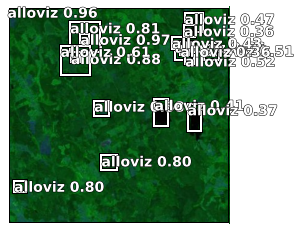

In [ ]:
#5. kep, 2.idx

imi = data.test_ds[2][0]
show_preds(imi, output, 0, detect_thresh=0.35, classes=data.classes)

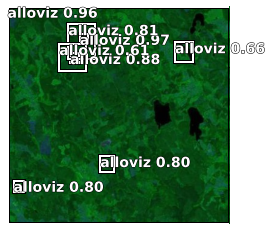

In [ ]:
#5. kep, 2.idx, .6 trsh

imi = data.test_ds[2][0]
show_preds(imi, output, 0, detect_thresh=0.6, classes=data.classes)

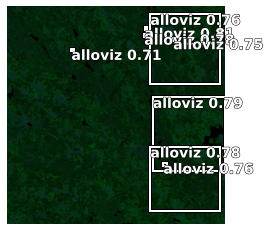

In [ ]:
# 6. kep, 3.idx
imi = data.test_ds[3][0]
show_preds(imi, output, 0, detect_thresh=0.7, classes=data.classes)

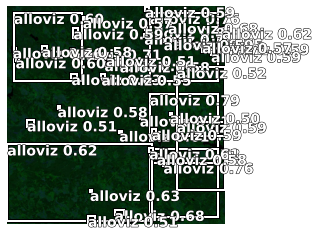

In [ ]:
#ugyanaz de 0.5 treshold
imi = data.test_ds[3][0]
show_preds(imi, output, 0, detect_thresh=0.5, classes=data.classes)

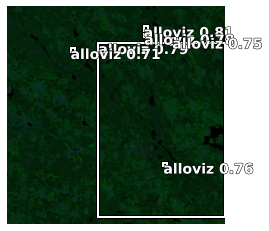

In [ ]:
#ugyanaz de 0.7 treshold, nagyobb anchor size
imi = data.test_ds[3][0]
show_preds(imi, output, 0, detect_thresh=0.7, classes=data.classes)

In [ ]:
imi.save("output_img6.jpg")

# Referenciák


- fastai pascal bbox: https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb
- vizualizáció: https://github.com/hamma95/pascal_detection/blob/master/pascal_detection.py